In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Embedding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Word Embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For reproducibility
import random
import os

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')


C:\Users\roy.xu23\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roy.xu23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roy.xu23\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Cell 2: Load Dataset
# Paths to CSV files
true_path = 'True.csv'
fake_path = 'Fake.csv'

# Load CSVs
true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

# Add a label column: 0 for True, 1 for Fake
true_df['label'] = 0
fake_df['label'] = 1

# Combine the datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Display the first few rows
df.head()


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


Dataset shape: (44898, 5)

Dataset columns: ['title', 'text', 'subject', 'date', 'label']

Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


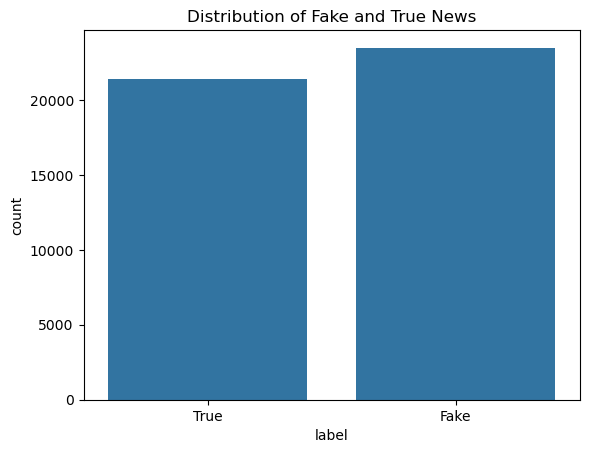


Sample True News:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs t

In [74]:
# Cell 3: Data Exploration
print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake and True News')
plt.xticks([0,1], ['True', 'Fake'])
plt.show()

# Display some sample texts
print("\nSample True News:")
print(df[df['label'] == 0]['text'].iloc[0])

print("\nSample Fake News:")
print(df[df['label'] == 1]['text'].iloc[0])


In [7]:
# Cell 4: Data Preprocessing Functions
# Initialize stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text, remove_stopwords=True, to_lower=True, remove_punctuation=True, perform_stemming=False, perform_lemmatization=False):
    # Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lowercase
    if to_lower:
        text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    
    # Optional: Stemming
    if perform_stemming:
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Optional: Lemmatization
    if perform_lemmatization:
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)


In [90]:
# Cell 5: Apply Different Preprocessing Steps
# Define different preprocessing configurations
preprocessing_steps = {
    'Basic': {'remove_stopwords': False, 'to_lower': False, 'remove_punctuation': False},
    'Lowercase': {'remove_stopwords': False, 'to_lower': True, 'remove_punctuation': False},
    'Lowercase & Remove Punctuation': {'remove_stopwords': False, 'to_lower': True, 'remove_punctuation': True},
    'Lowercase, Remove Punctuation & Stopwords': {'remove_stopwords': True, 'to_lower': True, 'remove_punctuation': True},
    'Full Preprocessing': {'remove_stopwords': True, 'to_lower': True, 'remove_punctuation': True, 'perform_stemming': True}
}

# Create a dictionary to store processed texts
processed_texts = {}

for step, params in preprocessing_steps.items():
    print(f"Applying preprocessing: {step}")
    processed = df['text'].apply(lambda x: preprocess_text(x, 
                                                           remove_stopwords=params.get('remove_stopwords', False),
                                                           to_lower=params.get('to_lower', False),
                                                           remove_punctuation=params.get('remove_punctuation', False),
                                                           perform_stemming=params.get('perform_stemming', False),
                                                           perform_lemmatization=params.get('perform_lemmatization', False)))
    processed_texts[step] = processed

# Example: Display processed texts
for step in preprocessing_steps.keys():
    print(f"\nSample text after '{step}' preprocessing:")
    print(processed_texts[step].iloc[0])


Applying preprocessing: Basic
Applying preprocessing: Lowercase
Applying preprocessing: Lowercase & Remove Punctuation
Applying preprocessing: Lowercase, Remove Punctuation & Stopwords
Applying preprocessing: Full Preprocessing

Sample text after 'Basic' preprocessing:
WASHINGTON ( Reuters ) - The head of a conservative Republican faction in the U.S. Congress , who voted this month for a huge expansion of the national debt to pay for tax cuts , called himself a “ fiscal conservative ” on Sunday and urged budget restraint in . In keeping with a sharp pivot under way among Republicans , U.S. Representative Mark Meadows , speaking on CBS ’ “ Face the Nation , ” drew a hard line on federal spending , which lawmakers are bracing to do battle over in January . When they return from the holidays on Wednesday , lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues , such as immigration policy , even as the November congressional election campaigns 

In [28]:
import os
import zipfile
import requests

def download_glove(destination_path='glove.6B.zip'):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    response = requests.get(url, stream=True)
    with open(destination_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    print("Downloaded GloVe embeddings.")

def extract_glove(zip_path='glove.6B.zip', extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extracted GloVe embeddings.")

# Download and extract
download_glove()
extract_glove()


Downloaded GloVe embeddings.
Extracted GloVe embeddings.


In [52]:
# Cell 6: Feature Extraction - Embedding Methods
# Define embedding methods
embedding_methods = ['OneHot', 'Word2Vec', 'GloVe', 'Doc2Vec', 'NaiveD2V']

# We will use the 'Full Preprocessing' for embedding
X = processed_texts['Full Preprocessing']
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Function for One-Hot Encoding
def one_hot_encode(train_texts, test_texts, max_features=5000):
    vectorizer = CountVectorizer(max_features=max_features)
    X_train_enc = vectorizer.fit_transform(train_texts).toarray()
    X_test_enc = vectorizer.transform(test_texts).toarray()
    return X_train_enc, X_test_enc, vectorizer

# Function for Word2Vec
def word2vec_embed(train_texts, test_texts, vector_size=100, window=5, min_count=1):
    # Tokenize
    train_tokens = [text.split() for text in train_texts]
    test_tokens = [text.split() for text in test_texts]
    
    # Train Word2Vec
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=vector_size, window=window, min_count=min_count, workers=4)
    
    # Function to get average Word2Vec vectors
    def get_avg_w2v(tokens, model, vector_size):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if len(vectors) == 0:
            return np.zeros(vector_size)
        else:
            return np.mean(vectors, axis=0)
    
    X_train_w2v = np.array([get_avg_w2v(tokens, w2v_model, vector_size) for tokens in train_tokens])
    X_test_w2v = np.array([get_avg_w2v(tokens, w2v_model, vector_size) for tokens in test_tokens])
    
    return X_train_w2v, X_test_w2v, w2v_model

# Function to load GloVe embeddings
def load_glove_embeddings(glove_file_path, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = ''.join(values[:-embedding_dim])
            coefs = np.asarray(values[-embedding_dim:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Loaded {len(embeddings_index)} word vectors from GloVe.')
    return embeddings_index

# Function for GloVe Embedding
def glove_embed(train_texts, test_texts, embeddings_index, embedding_dim=100):
    # Tokenize
    train_tokens = [text.split() for text in train_texts]
    test_tokens = [text.split() for text in test_texts]
    
    # Function to get average GloVe vectors
    def get_avg_glove(tokens, embeddings, dim):
        vectors = [embeddings[word] for word in tokens if word in embeddings]
        if len(vectors) == 0:
            return np.zeros(dim)
        else:
            return np.mean(vectors, axis=0)
    
    X_train_glove = np.array([get_avg_glove(tokens, embeddings_index, embedding_dim) for tokens in train_tokens])
    X_test_glove = np.array([get_avg_glove(tokens, embeddings_index, embedding_dim) for tokens in test_tokens])
    
    return X_train_glove, X_test_glove

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Function for Doc2Vec Embedding
def doc2vec_embed(train_texts, test_texts, vector_size=100, window=5, min_count=1, epochs=20):
    # Tag documents
    tagged_train = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(train_texts)]
    
    # Initialize Doc2Vec model
    d2v_model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4, epochs=epochs, dm=1)  # dm=1 for Distributed Memory
    
    # Build vocabulary
    d2v_model.build_vocab(tagged_train)
    
    # Train the model
    d2v_model.train(tagged_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
    
    # Infer vectors for training and test sets
    X_train_d2v = np.array([d2v_model.infer_vector(text.split()) for text in train_texts])
    X_test_d2v = np.array([d2v_model.infer_vector(text.split()) for text in test_texts])
    
    return X_train_d2v, X_test_d2v, d2v_model

# Function for NaiveD2V Embedding (Assumed as a simplified Doc2Vec)
def naived2v_embed(train_texts, test_texts, vector_size=100, window=5, min_count=1, epochs=20):
    tagged_train = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(train_texts)]
    
    # Initialize NaiveD2V model with a different configuration (e.g., dm=0 for Distributed Bag of Words)
    naived2v_model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4, epochs=epochs, dm=0)  # dm=0 for DBOW
    
    # Build vocabulary
    naived2v_model.build_vocab(tagged_train)
    
    # Train the model
    naived2v_model.train(tagged_train, total_examples=naived2v_model.corpus_count, epochs=naived2v_model.epochs)
    
    # Infer vectors for training and test sets
    X_train_naived2v = np.array([naived2v_model.infer_vector(text.split()) for text in train_texts])
    X_test_naived2v = np.array([naived2v_model.infer_vector(text.split()) for text in test_texts])
    
    return X_train_naived2v, X_test_naived2v, naived2v_model

# Apply Doc2Vec
X_train_d2v, X_test_d2v, d2v_model = doc2vec_embed(X_train, X_test, vector_size=100, window=5, min_count=1, epochs=20)
print("Doc2Vec Embedding shape:", X_train_d2v.shape)

# # Apply NaiveD2V
# X_train_naived2v, X_test_naived2v, naived2v_model = naived2v_embed(X_train, X_test, vector_size=100, window=5, min_count=1, epochs=20)
# print("NaiveD2V Embedding shape:", X_train_naived2v.shape)

# # Apply One-Hot Encoding
# X_train_oh, X_test_oh, vectorizer_oh = one_hot_encode(X_train, X_test, max_features=5000)
# print("One-Hot Encoding shape:", X_train_oh.shape)

# # Apply Word2Vec
# X_train_w2v, X_test_w2v, w2v_model = word2vec_embed(X_train, X_test, vector_size=100)
# print("Word2Vec Embedding shape:", X_train_w2v.shape)

# # Load GloVe embeddings
# glove_path = 'glove.6B.100d.txt'
# embeddings_glove = load_glove_embeddings(glove_path, embedding_dim=100)

# # Apply GloVe Embedding
# X_train_glove, X_test_glove = glove_embed(X_train, X_test, embeddings_glove, embedding_dim=100)
# print("GloVe Embedding shape:", X_train_glove.shape)


Doc2Vec Embedding shape: (35918, 100)
NaiveD2V Embedding shape: (35918, 100)
One-Hot Encoding shape: (35918, 5000)
Word2Vec Embedding shape: (35918, 100)
Loaded 400000 word vectors from GloVe.
GloVe Embedding shape: (35918, 100)


In [60]:
# Cell 7: Define Feedforward Neural Network with Variable Hidden Layers
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[], output_size=1, dropout=0.5):
        super(FFNN, self).__init__()
        layers = []
        last_size = input_size
        for hidden in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            last_size = hidden
        layers.append(nn.Linear(last_size, output_size))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)



In [56]:
# Cell 8: Prepare Datasets and DataLoaders
class NewsDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to create DataLoaders
def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=64):
    train_dataset = NewsDataset(X_train, y_train)
    test_dataset = NewsDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader



In [62]:
# Cell 9: Training and Evaluation Functions
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score + self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

def train_model_with_early_stopping(model, train_loader, criterion, optimizer, epochs=20, device='cpu', patience=3, metric='f1'):
    model.to(device)
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_correct = 0
        all_preds = []
        all_labels = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            epoch_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
        
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, zero_division=0)
        epoch_recall = recall_score(all_labels, all_preds, zero_division=0)
        epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        history['precision'].append(epoch_precision)
        history['recall'].append(epoch_recall)
        history['f1'].append(epoch_f1)
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Precision: {epoch_precision:.4f} - Recall: {epoch_recall:.4f} - F1: {epoch_f1:.4f}')
        
        # Check early stopping
        current_score = epoch_f1 if metric == 'f1' else epoch_acc
        early_stopping(current_score)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
    
    return history

def evaluate_model_detailed(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['True', 'Fake'], zero_division=0)
    
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}\n')
    print('Classification Report:')
    print(report)
    print('Confusion Matrix:')
    print(cm)
    
    return acc, precision, recall, f1, cm, report


In [66]:
# Cell 10: Train and Evaluate All Preprocessing-Embedding Combinations

# Define embedding methods
embedding_methods = ['OneHot', 'Word2Vec', 'GloVe', 'Doc2Vec', 'NaiveD2V']

# Function to apply embeddings based on method
def apply_embedding(method, processed_texts, train_texts, test_texts):
    if method == 'OneHot':
        return one_hot_encode(train_texts, test_texts, max_features=5000)
    elif method == 'Word2Vec':
        return word2vec_embed(train_texts, test_texts, vector_size=100)
    elif method == 'GloVe':
        return glove_embed(train_texts, test_texts, embeddings_glove, embedding_dim=100)
    elif method == 'Doc2Vec':
        return doc2vec_embed(train_texts, test_texts, vector_size=100, window=5, min_count=1, epochs=20)
    elif method == 'NaiveD2V':
        return naived2v_embed(train_texts, test_texts, vector_size=100, window=5, min_count=1, epochs=20)
    else:
        raise ValueError("Unsupported embedding method.")

# Store results
results = {}

# Iterate over each preprocessing step
for prep_name, processed_texts in processed_texts.items():
    print(f"=== Preprocessing Step: {prep_name} ===")
    
    # Prepare features and labels
    X = processed_texts
    y = df['label']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Iterate over each embedding method
    for embed_method in embedding_methods:
        print(f"\n--- Embedding Method: {embed_method} ---")
        
        # Apply embedding
        try:
            if embed_method == 'GloVe':
                X_train_emb, X_test_emb = glove_embed(X_train, X_test, embeddings_glove, embedding_dim=100)
                # Handle potential issues if 'GloVe' embeddings are not loaded
            else:
                X_train_emb, X_test_emb, _ = apply_embedding(embed_method, processed_texts, X_train, X_test)
        except Exception as e:
            print(f"Embedding {embed_method} failed with error: {e}")
            continue
        
        print(f"Embedding {embed_method} shape: {X_train_emb.shape}")
        
        # Create DataLoaders
        train_loader, test_loader = create_dataloaders(X_train_emb, X_test_emb, y_train, y_test, batch_size=64)
        
        # Define model architecture
        input_size = X_train_emb.shape[1]
        hidden_sizes = [128, 64]  # Default hidden layers; can be adjusted
        model = FFNN(input_size=input_size, hidden_sizes=hidden_sizes, dropout=0.5)
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model with early stopping
        history = train_model_with_early_stopping(
            model, train_loader, criterion, optimizer,
            epochs=20, device=device, patience=3, metric='f1'
        )
        
        # Evaluate the model
        print("\nEvaluation on Test Set:")
        acc, precision, recall, f1, cm, report = evaluate_model_detailed(model, test_loader, device)
        
        # Store the results
        key = f"{prep_name} + {embed_method}"
        results[key] = {
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm,
            'Classification Report': report,
            'Training History': history
        }
        
        print("\n" + "="*80 + "\n")

# Display a summary of results
summary = pd.DataFrame({
    'Combination': list(results.keys()),
    'Accuracy': [v['Accuracy'] for v in results.values()],
    'Precision': [v['Precision'] for v in results.values()],
    'Recall': [v['Recall'] for v in results.values()],
    'F1 Score': [v['F1 Score'] for v in results.values()]
})

print("=== Summary of All Preprocessing-Embedding Combinations ===")
display(summary.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


=== Preprocessing Step: Basic ===

--- Embedding Method: OneHot ---
Embedding OneHot shape: (35918, 5000)
Epoch 1/20 - Loss: 0.1198 - Acc: 0.9687 - Precision: 0.9728 - Recall: 0.9672 - F1: 0.9700
Epoch 2/20 - Loss: 0.0403 - Acc: 0.9936 - Precision: 0.9944 - Recall: 0.9933 - F1: 0.9938
Epoch 3/20 - Loss: 0.0241 - Acc: 0.9957 - Precision: 0.9961 - Recall: 0.9956 - F1: 0.9959
Epoch 4/20 - Loss: 0.0322 - Acc: 0.9951 - Precision: 0.9958 - Recall: 0.9949 - F1: 0.9953
Epoch 5/20 - Loss: 0.0243 - Acc: 0.9967 - Precision: 0.9965 - Recall: 0.9972 - F1: 0.9968
Epoch 6/20 - Loss: 0.0170 - Acc: 0.9981 - Precision: 0.9982 - Recall: 0.9981 - F1: 0.9982
Epoch 7/20 - Loss: 0.0179 - Acc: 0.9980 - Precision: 0.9981 - Recall: 0.9981 - F1: 0.9981
Epoch 8/20 - Loss: 0.0150 - Acc: 0.9981 - Precision: 0.9979 - Recall: 0.9984 - F1: 0.9982
Epoch 9/20 - Loss: 0.0143 - Acc: 0.9985 - Precision: 0.9985 - Recall: 0.9987 - F1: 0.9986
Early stopping triggered.

Evaluation on Test Set:
Test Accuracy: 0.9961
Test Precis

KeyboardInterrupt: 

In [91]:
# Cell 10: Train and Evaluate Selected Preprocessing-Embedding Combinations

# Define a mapping of embedding methods to suitable preprocessing steps
embedding_preprocessing_map = {
    'OneHot': ['Lowercase', 'Lowercase & Remove Punctuation'],
    'Word2Vec': ['Lowercase & Remove Punctuation', 'Lowercase, Remove Punctuation & Stopwords', 'Full Preprocessing'],
    'GloVe': ['Lowercase & Remove Punctuation', 'Lowercase, Remove Punctuation & Stopwords', 'Full Preprocessing'],
    'Doc2Vec': ['Lowercase & Remove Punctuation', 'Lowercase, Remove Punctuation & Stopwords'],
    'NaiveD2V': ['Lowercase & Remove Punctuation', 'Lowercase, Remove Punctuation & Stopwords']
}

# Store results
results = {}

# Iterate over each embedding method and their corresponding preprocessing steps
for embed_method, prep_steps in embedding_preprocessing_map.items():
    print(f"=== Embedding Method: {embed_method} ===")


    
    for prep_name in prep_steps:
        print(f"\n--- Preprocessing Step: {prep_name} ---")

        print(processed_texts['Lowercase'])
        # Prepare features and labels
        X = processed_texts[prep_name]
        y = df['label']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Apply embedding
        try:
            if embed_method == 'GloVe':
                X_train_emb, X_test_emb = glove_embed(X_train, X_test, embeddings_glove, embedding_dim=100)
            elif embed_method in ['Doc2Vec', 'NaiveD2V']:
                X_train_emb, X_test_emb, _ = apply_embedding(embed_method, processed_texts, X_train, X_test)
            else:
                X_train_emb, X_test_emb, _ = apply_embedding(embed_method, processed_texts, X_train, X_test)
        except Exception as e:
            print(f"Embedding {embed_method} with preprocessing '{prep_name}' failed with error: {e}")
            continue
        
        print(f"Embedding {embed_method} with '{prep_name}' shape: {X_train_emb.shape}")
        
        # Create DataLoaders
        train_loader, test_loader = create_dataloaders(X_train_emb, X_test_emb, y_train, y_test, batch_size=64)
        
        # Define model architecture
        input_size = X_train_emb.shape[1]
        hidden_sizes = [128, 64]  # Default hidden layers; can be adjusted
        model = FFNN(input_size=input_size, hidden_sizes=hidden_sizes, dropout=0.5)
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model with early stopping
        history = train_model_with_early_stopping(
            model, train_loader, criterion, optimizer,
            epochs=20, device=device, patience=3, metric='f1'
        )
        
        # Evaluate the model
        print("\nEvaluation on Test Set:")
        acc, precision, recall, f1, cm, report = evaluate_model_detailed(model, test_loader, device)
        
        # Store the results
        key = f"{embed_method} + {prep_name}"
        results[key] = {
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm,
            'Classification Report': report,
            'Training History': history
        }
        
        print("\n" + "="*80 + "\n")

# Display a summary of results
summary = pd.DataFrame({
    'Combination': list(results.keys()),
    'Accuracy': [v['Accuracy'] for v in results.values()],
    'Precision': [v['Precision'] for v in results.values()],
    'Recall': [v['Recall'] for v in results.values()],
    'F1 Score': [v['F1 Score'] for v in results.values()]
})

print("=== Summary of Selected Preprocessing-Embedding Combinations ===")
display(summary.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


=== Embedding Method: OneHot ===

--- Preprocessing Step: Lowercase ---
0        washington ( reuters ) - the head of a conserv...
1        washington ( reuters ) - transgender people wi...
2        washington ( reuters ) - the special counsel i...
3        washington ( reuters ) - trump campaign advise...
4        seattle/washington ( reuters ) - president don...
                               ...                        
44893    st century wire says as wire reported earlier ...
44894    st century wire says it s a familiar theme . w...
44895    patrick henningsen st century wireremember whe...
44896    st century wire says al jazeera america will g...
44897    st century wire says as wire predicted in its ...
Name: text, Length: 44898, dtype: object
Embedding OneHot with 'Lowercase' shape: (35918, 5000)
Epoch 1/20 - Loss: 0.1196 - Acc: 0.9675 - Precision: 0.9759 - Recall: 0.9616 - F1: 0.9687
Epoch 2/20 - Loss: 0.0475 - Acc: 0.9928 - Precision: 0.9934 - Recall: 0.9928 - F1: 0.9931
Epo

,Combination,Accuracy,Precision,Recall,F1 Score
0,"NaiveD2V + Lowercase, Remove Punctuation & Sto...",0.997439,0.998294,0.996806,0.997549
1,NaiveD2V + Lowercase & Remove Punctuation,0.996548,0.997441,0.995954,0.996697
2,OneHot + Lowercase,0.995768,0.998288,0.993612,0.995945
3,OneHot + Lowercase & Remove Punctuation,0.994432,0.994676,0.994676,0.994676
4,"Word2Vec + Lowercase, Remove Punctuation & Sto...",0.990089,0.994207,0.986797,0.990488
5,Doc2Vec + Lowercase & Remove Punctuation,0.988864,0.985220,0.993612,0.989398
6,Word2Vec + Full Preprocessing,0.988530,0.987476,0.990630,0.989051
7,Word2Vec + Lowercase & Remove Punctuation,0.987862,0.985602,0.991269,0.988428
8,"Doc2Vec + Lowercase, Remove Punctuation & Stop...",0.983964,0.977950,0.991695,0.984775
9,"GloVe + Lowercase, Remove Punctuation & Stopwords",0.979065,0.984731,0.975085,0.979884


In [94]:
# Cell 11: Analyze and Select Best Preprocessing-Embedding Pairs

# Extract the best combination based on F1 Score
best_combination = summary.sort_values(by='F1 Score', ascending=False).iloc[0]
print(f"Best Preprocessing + Embedding Combination: {best_combination['Combination']}")
print(f"Accuracy: {best_combination['Accuracy']:.4f}")
print(f"Precision: {best_combination['Precision']:.4f}")
print(f"Recall: {best_combination['Recall']:.4f}")
print(f"F1 Score: {best_combination['F1 Score']:.4f}")

# Identify the preprocessing and embedding method
best_prep, best_embed = best_combination['Combination'].split(' + ')

print("\nDetails of the Best Model:")
print(results[best_combination['Combination']]['Classification Report'])
print("Confusion Matrix:")
print(results[best_combination['Combination']]['Confusion Matrix'])


Best Preprocessing + Embedding Combination: NaiveD2V + Lowercase, Remove Punctuation & Stopwords
Accuracy: 0.9974
Precision: 0.9983
Recall: 0.9968
F1 Score: 0.9975

Details of the Best Model:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
[[4276    8]
 [  15 4681]]


In [112]:
# Cell 13: Hyperparameter Tuning with Randomized Search

from sklearn.model_selection import ParameterSampler
import random

# Function for hyperparameter tuning using Randomized Search
def randomized_hyperparameter_tuning(
    model_class,
    train_loader,
    test_loader,
    device,
    param_distributions,
    n_iter=20,
    metric='f1'
):
    """
    Performs randomized hyperparameter tuning.

    Args:
        model_class: The neural network class.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for test data.
        device: Device to run the model on ('cpu' or 'cuda').
        param_distributions: Dictionary with hyperparameters to sample.
        n_iter: Number of parameter settings sampled.
        metric: Metric to optimize ('accuracy' or 'f1').

    Returns:
        best_params: The best hyperparameters found.
        best_score: The best score achieved.
    """
    # Generate random hyperparameter combinations
    sampled_params = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))
    
    best_score = -1
    best_params = None
    
    for idx, params in enumerate(sampled_params):
        print(f"\n--- Hyperparameter Combination {idx+1}/{n_iter} ---")
        print(f"Parameters: {params}")
        
        # Extract hyperparameters
        lr = params.get('learning_rate', 0.001)
        hidden_sizes = params.get('hidden_sizes', [128, 64])
        dropout = params.get('dropout', 0.5)
        epochs = params.get('epochs', 20)
        patience = params.get('patience', 3)
        
        # Define the model
        model = model_class(
            input_size=X_train_emb.shape[1],
            hidden_sizes=hidden_sizes,
            dropout=dropout
        )
        
        # Move model to device
        model.to(device)
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Initialize Early Stopping
        early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
        
        # Training loop
        model.train()
        for epoch in range(1, epochs + 1):
            epoch_loss = 0
            all_preds = []
            all_labels = []
            
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item() * X_batch.size(0)
                
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
            
            epoch_loss /= len(train_loader.dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)
            
            print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - F1: {epoch_f1:.4f}")
            
            # Check early stopping
            current_score = epoch_f1 if metric == 'f1' else epoch_acc
            early_stopping(current_score)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        
        # Evaluate on test set
        print("Evaluating on test set...")
        acc, precision, recall, f1, cm, report = evaluate_model_detailed(model, test_loader, device)
        
        # Determine if this is the best model so far
        score = f1 if metric == 'f1' else acc
        if score > best_score:
            best_score = score
            best_params = params
            print("New best model found!")
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best {metric.upper()}: {best_score:.4f}")
    
    return best_params, best_score

# Define the hyperparameter grid
param_distributions = {
    'learning_rate': [0.001, 0.0005, 0.0001, 0.005],
    'hidden_sizes': [
        [128, 64],
        [256, 128],
        [128, 64, 32],
        [256, 128, 64],
        [512, 256, 128]
    ],
    'dropout': [0.3, 0.5, 0.7],
    'epochs': [20, 30, 40],
    'patience': [3, 5, 7]
}

# Identify the best preprocessing-embedding combination from previous steps
# Assuming 'Best Combination' is stored in best_combination variable
# For demonstration, let's use the previously identified best_comb_key
best_comb_key = best_combination['Combination']
best_embed, best_prep = best_comb_key.split(' + ')
print(f"Selected Best Preprocessing: {best_prep}")
print(f"Selected Best Embedding: {best_embed}")

# Extract the corresponding training and test data
# Reapply the best preprocessing and embedding
print(f"\nReapplying Best Preprocessing: {best_prep} and Embedding: {best_embed}")
best_processed_texts = processed_texts[best_prep]

# Split the data
X = best_processed_texts
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply the best embedding
if best_embed == 'OneHot':
    X_train_emb, X_test_emb, vectorizer = one_hot_encode(X_train, X_test, max_features=5000)
elif best_embed == 'Word2Vec':
    X_train_emb, X_test_emb, w2v_model = word2vec_embed(X_train, X_test, vector_size=100)
elif best_embed == 'GloVe':
    X_train_emb, X_test_emb = glove_embed(X_train, X_test, embeddings_glove, embedding_dim=100)
elif best_embed == 'Doc2Vec':
    X_train_emb, X_test_emb, d2v_model = doc2vec_embed(X_train, X_test, vector_size=100, window=5, min_count=1, epochs=20)
elif best_embed == 'NaiveD2V':
    X_train_emb, X_test_emb, naived2v_model = naived2v_embed(X_train, X_test, vector_size=100, window=5, min_count=1, epochs=20)
else:
    raise ValueError("Unsupported embedding method.")

print(f"Embedding {best_embed} shape: {X_train_emb.shape}")

# Create DataLoaders
train_loader, test_loader = create_dataloaders(X_train_emb, X_test_emb, y_train, y_test, batch_size=64)

# Perform Randomized Hyperparameter Tuning
print("\nStarting Randomized Hyperparameter Tuning...")
best_params, best_score = randomized_hyperparameter_tuning(
    model_class=FFNN,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    param_distributions=param_distributions,
    n_iter=20,
    metric='f1'  # Optimize based on F1 Score
)

# Retrain the model with the best hyperparameters
print("\nRetraining the model with the best hyperparameters...")
best_lr = best_params['learning_rate']
best_hidden_sizes = best_params['hidden_sizes']
best_dropout = best_params['dropout']
best_epochs = best_params['epochs']
best_patience = best_params['patience']

# Define the best model
best_model = FFNN(
    input_size=X_train_emb.shape[1],
    hidden_sizes=best_hidden_sizes,
    dropout=best_dropout
)
best_model.to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=best_patience, min_delta=0.001)

# Training loop with early stopping
best_model.train()
for epoch in range(1, best_epochs + 1):
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)
        
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    
    epoch_loss /= len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    print(f"Epoch {epoch}/{best_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - F1: {epoch_f1:.4f}")
    
    # Check early stopping
    current_score = epoch_f1
    early_stopping(current_score)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Final Evaluation
print("\nFinal Evaluation on Test Set:")
final_acc, final_precision, final_recall, final_f1, final_cm, final_report = evaluate_model_detailed(best_model, test_loader, device)

# Save the best model
model_path = 'best_ffnn_model_final.pth'
torch.save(best_model.state_dict(), model_path)
print(f"\nBest Model saved to {model_path}")


Selected Best Preprocessing: Lowercase, Remove Punctuation & Stopwords
Selected Best Embedding: NaiveD2V

Reapplying Best Preprocessing: Lowercase, Remove Punctuation & Stopwords and Embedding: NaiveD2V
Embedding NaiveD2V shape: (35918, 100)

Starting Randomized Hyperparameter Tuning...

--- Hyperparameter Combination 1/20 ---
Parameters: {'patience': 5, 'learning_rate': 0.001, 'hidden_sizes': [512, 256, 128], 'epochs': 20, 'dropout': 0.5}
Epoch 1/20 - Loss: 0.0635 - Acc: 0.9771 - F1: 0.9783
Epoch 2/20 - Loss: 0.0223 - Acc: 0.9928 - F1: 0.9931
Epoch 3/20 - Loss: 0.0148 - Acc: 0.9950 - F1: 0.9953
Epoch 4/20 - Loss: 0.0104 - Acc: 0.9964 - F1: 0.9965
Epoch 5/20 - Loss: 0.0097 - Acc: 0.9967 - F1: 0.9969
Epoch 6/20 - Loss: 0.0082 - Acc: 0.9976 - F1: 0.9977
Epoch 7/20 - Loss: 0.0079 - Acc: 0.9975 - F1: 0.9976
Epoch 8/20 - Loss: 0.0070 - Acc: 0.9978 - F1: 0.9979
Epoch 9/20 - Loss: 0.0068 - Acc: 0.9978 - F1: 0.9979
Epoch 10/20 - Loss: 0.0062 - Acc: 0.9980 - F1: 0.9981
Epoch 11/20 - Loss: 0.004

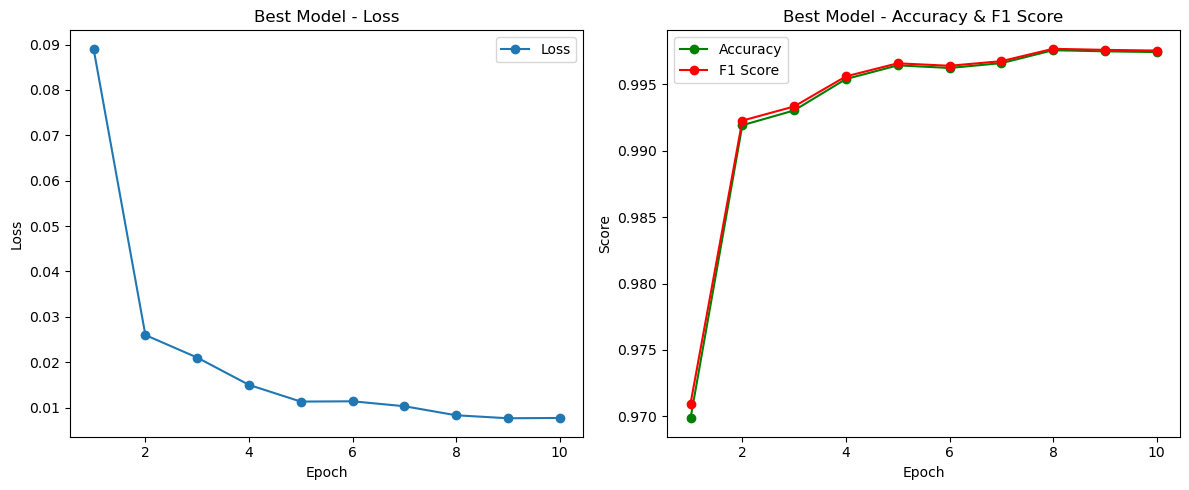

In [113]:
# Cell 14: Visualize Training Loss and Accuracy

import matplotlib.pyplot as plt

def plot_training_history(history, title='Training History'):
    epochs = range(1, len(history['loss']) + 1)
    
    plt.figure(figsize=(12,5))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['loss'], label='Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    # Plot Accuracy and F1 Score
    plt.subplot(1,2,2)
    plt.plot(epochs, history['accuracy'], label='Accuracy', color='green', marker='o')
    plt.plot(epochs, history['f1'], label='F1 Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(f'{title} - Accuracy & F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming 'history' from the final training loop is available
plot_training_history(history, title='Best Model')


In [118]:
# Cell 15: Comprehensive Error Analysis for the Best Model

def error_analysis(model, test_loader, X_test, y_test, embedding_name):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Create a DataFrame for analysis
    analysis_df = pd.DataFrame({
        'Text': X_test.tolist(),
        'True Label': all_labels,
        'Predicted Label': all_preds
    })
    
    # Misclassified examples
    misclassified = analysis_df[analysis_df['True Label'] != analysis_df['Predicted Label']]
    print(f"\nNumber of misclassified examples ({embedding_name}): {len(misclassified)})")
    
    # Display some misclassified examples
    print(f"\nSample Misclassified True News ({embedding_name}):")
    print(misclassified[misclassified['True Label'] == 0]['Text'].iloc[:2].to_string(index=False))
    
    print(f"\nSample Misclassified Fake News ({embedding_name}):")
    print(misclassified[misclassified['True Label'] == 1]['Text'].iloc[:2].to_string(index=False))

# Perform error analysis for the best model
error_analysis(best_model, test_loader, X_test_emb, y_test, 'Best Model')



Number of misclassified examples (Best Model): 34)

Sample Misclassified True News (Best Model):
[0.09165693074464798, 0.38286423683166504, 0.16...
[0.9032797813415527, 0.028670432046055794, -0.3...

Sample Misclassified Fake News (Best Model):
[-0.04923251271247864, 0.5588398575782776, -0.7...
[-0.22259099781513214, -0.8126096725463867, -0....


=== Best Model Evaluation Metrics ===
Accuracy: 0.9962
Precision: 0.9962
Recall: 0.9966
F1 Score: 0.9964

=== Classification Report ===
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

=== Confusion Matrix ===
[[4266   18]
 [  16 4680]]


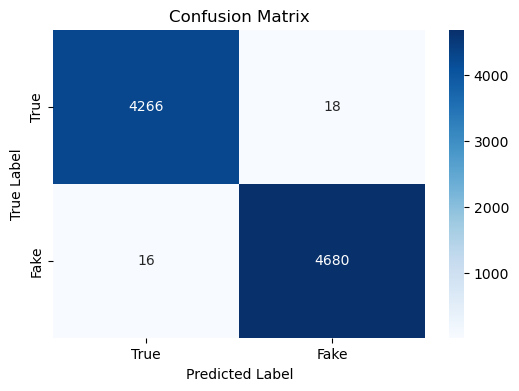


=== Best Hyperparameters ===
patience: 5
learning_rate: 0.0001
hidden_sizes: [512, 256, 128]
epochs: 20
dropout: 0.3


In [120]:
# Cell 14: Print and Visualize Statistics for the Best Model

# 1. Print Evaluation Metrics
print("=== Best Model Evaluation Metrics ===")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")

# 2. Print Classification Report
print("\n=== Classification Report ===")
print(final_report)

# 3. Print Confusion Matrix
print("=== Confusion Matrix ===")
print(final_cm)

# 4. Visualize Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Print Best Hyperparameters
print("\n=== Best Hyperparameters ===")
for param, value in best_params.items():
    print(f"{param}: {value}")


In [39]:
# Cell 11: Hyperparameter Tuning with RandomizedSearch

# For simplicity, we'll tune the learning rate and hidden sizes
from itertools import product

def hyperparameter_tuning(embedding_name, X_train, X_test, y_train, y_test, param_grid, iterations=10):
    print(f"\nHyperparameter Tuning for {embedding_name} embedding")
    best_acc = 0
    best_params = {}
    
    # Generate random combinations
    param_combinations = list(product(*param_grid.values()))
    random.shuffle(param_combinations)
    param_combinations = param_combinations[:iterations]
    
    for params in param_combinations:
        lr, hidden1, hidden2 = params
        print(f"\nTraining with lr={lr}, hidden_sizes=[{hidden1}, {hidden2}]")
        
        # Create DataLoaders
        train_loader, test_loader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size)
        
        # Define model
        input_size = X_train.shape[1]
        model = FFNN(input_size=input_size, hidden_sizes=[hidden1, hidden2], dropout=dropout)
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Train the model
        train_model(model, train_loader, criterion, optimizer, epochs, device)
        
        # Evaluate the model
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Test Accuracy: {acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            best_params = {'learning_rate': lr, 'hidden1': hidden1, 'hidden2': hidden2}
    
    print(f"\nBest Params: {best_params}, Best Accuracy: {best_acc:.4f}")
    return best_params, best_acc

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.01],
    'hidden1': [64, 128, 256],
    'hidden2': [32, 64, 128]
}

# Perform hyperparameter tuning on GloVe embedding
best_params_glove, best_acc_glove = hyperparameter_tuning('GloVe', X_train_glove, X_test_glove, y_train, y_test, param_grid, iterations=9)



Hyperparameter Tuning for GloVe embedding

Training with lr=0.001, hidden_sizes=[128, 32]
Epoch 1/10 - Loss: 0.2742 - Accuracy: 0.8916
Epoch 2/10 - Loss: 0.1675 - Accuracy: 0.9410
Epoch 3/10 - Loss: 0.1510 - Accuracy: 0.9469
Epoch 4/10 - Loss: 0.1371 - Accuracy: 0.9520
Epoch 5/10 - Loss: 0.1285 - Accuracy: 0.9558
Epoch 6/10 - Loss: 0.1220 - Accuracy: 0.9571
Epoch 7/10 - Loss: 0.1195 - Accuracy: 0.9583
Epoch 8/10 - Loss: 0.1147 - Accuracy: 0.9604
Epoch 9/10 - Loss: 0.1093 - Accuracy: 0.9616
Epoch 10/10 - Loss: 0.1077 - Accuracy: 0.9627
Test Accuracy: 0.9671

Training with lr=0.0001, hidden_sizes=[128, 128]
Epoch 1/10 - Loss: 0.5136 - Accuracy: 0.7816
Epoch 2/10 - Loss: 0.2526 - Accuracy: 0.9017
Epoch 3/10 - Loss: 0.2038 - Accuracy: 0.9212
Epoch 4/10 - Loss: 0.1834 - Accuracy: 0.9311
Epoch 5/10 - Loss: 0.1729 - Accuracy: 0.9344
Epoch 6/10 - Loss: 0.1647 - Accuracy: 0.9385
Epoch 7/10 - Loss: 0.1574 - Accuracy: 0.9403
Epoch 8/10 - Loss: 0.1545 - Accuracy: 0.9428
Epoch 9/10 - Loss: 0.1495 

In [40]:
# Cell 12: Retrain the Best Model with Best Hyperparameters
print("\nRetraining the best GloVe model with best hyperparameters.")

# Extract best parameters
best_lr = best_params_glove['learning_rate']
best_hidden1 = best_params_glove['hidden1']
best_hidden2 = best_params_glove['hidden2']

# Create DataLoaders
train_loader_glove, test_loader_glove = create_dataloaders(X_train_glove, X_test_glove, y_train, y_test, batch_size)

# Define model
model_best = FFNN(input_size=X_train_glove.shape[1], hidden_sizes=[best_hidden1, best_hidden2], dropout=dropout)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_best.parameters(), lr=best_lr)

# Train the model
train_model(model_best, train_loader_glove, criterion, optimizer, epochs, device)

# Evaluate the model
evaluate_model(model_best, test_loader_glove, device)



Retraining the best GloVe model with best hyperparameters.
Epoch 1/10 - Loss: 0.2734 - Accuracy: 0.8937
Epoch 2/10 - Loss: 0.1716 - Accuracy: 0.9366
Epoch 3/10 - Loss: 0.1518 - Accuracy: 0.9448
Epoch 4/10 - Loss: 0.1404 - Accuracy: 0.9507
Epoch 5/10 - Loss: 0.1330 - Accuracy: 0.9541
Epoch 6/10 - Loss: 0.1241 - Accuracy: 0.9562
Epoch 7/10 - Loss: 0.1207 - Accuracy: 0.9572
Epoch 8/10 - Loss: 0.1170 - Accuracy: 0.9597
Epoch 9/10 - Loss: 0.1105 - Accuracy: 0.9609
Epoch 10/10 - Loss: 0.1080 - Accuracy: 0.9626
Test Accuracy: 0.9676
Classification Report:
              precision    recall  f1-score   support

        True       0.96      0.97      0.97      4284
        Fake       0.97      0.96      0.97      4696

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Confusion Matrix:
[[4160  124]
 [ 167 4529]]


In [41]:
# Cell 13: Save and Load the Model
# Save the model
model_path = 'best_ffnn_model.pth'
torch.save(model_best.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load the model
loaded_model = FFNN(input_size=X_train_glove.shape[1], hidden_sizes=[best_hidden1, best_hidden2], dropout=dropout)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)
print("Model loaded successfully.")

# Verify loaded model's performance
evaluate_model(loaded_model, test_loader_glove, device)


Model saved to best_ffnn_model.pth
Model loaded successfully.
Test Accuracy: 0.9676
Classification Report:
              precision    recall  f1-score   support

        True       0.96      0.97      0.97      4284
        Fake       0.97      0.96      0.97      4696

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Confusion Matrix:
[[4160  124]
 [ 167 4529]]


C:\Users\roy.xu23\AppData\Local\Temp\ipykernel_15032\1197247328.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))



Retraining the best GloVe model with history tracking.
Epoch 1/10 - Loss: 0.2673 - Accuracy: 0.8934
Epoch 2/10 - Loss: 0.1690 - Accuracy: 0.9389
Epoch 3/10 - Loss: 0.1530 - Accuracy: 0.9454
Epoch 4/10 - Loss: 0.1388 - Accuracy: 0.9514
Epoch 5/10 - Loss: 0.1289 - Accuracy: 0.9545
Epoch 6/10 - Loss: 0.1230 - Accuracy: 0.9572
Epoch 7/10 - Loss: 0.1192 - Accuracy: 0.9585
Epoch 8/10 - Loss: 0.1164 - Accuracy: 0.9589
Epoch 9/10 - Loss: 0.1126 - Accuracy: 0.9604
Epoch 10/10 - Loss: 0.1059 - Accuracy: 0.9624


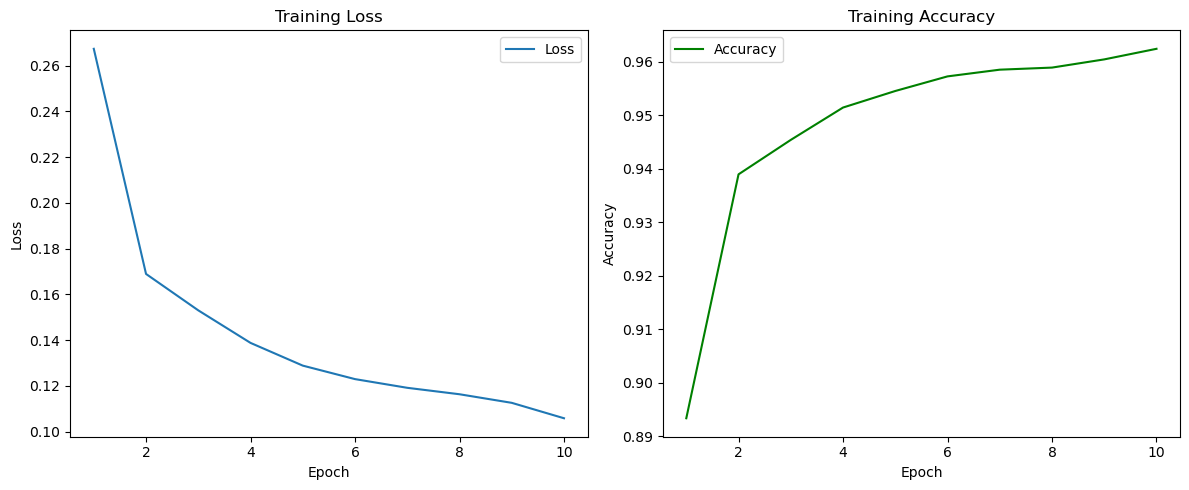

In [42]:
# Cell 14: Visualize Training Loss and Accuracy
def train_model_with_history(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)
    model.train()
    history = {'loss': [], 'accuracy': []}
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            epoch_acc += (preds == y_batch).sum().item()
        
        epoch_loss /= len(train_loader.dataset)
        epoch_acc /= len(train_loader.dataset)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')
    return history

# Retrain the best model and capture history
print("\nRetraining the best GloVe model with history tracking.")
model_best_history = FFNN(input_size=X_train_glove.shape[1], hidden_sizes=[best_hidden1, best_hidden2], dropout=dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_best_history.parameters(), lr=best_lr)
history = train_model_with_history(model_best_history, train_loader_glove, criterion, optimizer, epochs, device)

# Plotting Loss and Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), history['accuracy'], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# Cell 15: Error Analysis
# Get predictions and true labels
def get_predictions(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    all_texts = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return all_preds, all_labels

# Assuming you have the test texts
test_texts = X_test.tolist()

# Get predictions
preds, labels = get_predictions(model_best, test_loader_glove, device)

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Text': test_texts,
    'True Label': labels,
    'Predicted Label': preds
})

# Misclassified examples
misclassified = analysis_df[analysis_df['True Label'] != analysis_df['Predicted Label']]
print(f"Number of misclassified examples: {len(misclassified)}")

# Display some misclassified examples
print("\nSample Misclassified True News:")
print(misclassified[misclassified['True Label'] == 0]['Text'].iloc[:2])

print("\nSample Misclassified Fake News:")
print(misclassified[misclassified['True Label'] == 1]['Text'].iloc[:2])


Number of misclassified examples: 291

Sample Misclassified True News:
177    islamkot pakistan reuter pakistan bet cheap co...
196    london reuter project look link mental health ...
Name: Text, dtype: object

Sample Misclassified Fake News:
0     amateur presid donald trump hostil toward envi...
17    borderless travel europ die polit victim massm...
Name: Text, dtype: object
